In [110]:
import random

random_seed = 10
random.seed(random_seed)

In [111]:
!pip install gensim

In [112]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')


from google.colab import drive
drive.mount('/content/gdrive')

#Shared drive version at everyone can set up
df = pd.read_csv('/content/gdrive/MyDrive/Group 3: palm oil topic classifier/Data/palm_oil_grievance_logs.csv')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [113]:
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models.phrases import Phrases, Phraser


In [114]:

import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

## Model Creation Functions

In [115]:
def load_data_from_dataframe(df_column):
    """
    Input  : Pandas Series (e.g., grievances_df['summary'])
    Purpose: Load text data from a DataFrame column
    Output : list of documents and list of titles (first 100 characters)
    """
    documents_list = df_column.dropna().tolist()
    titles = [doc[:100] for doc in documents_list]
    print("Total Number of Documents:", len(documents_list))
    return documents_list, titles

In [116]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [117]:

# Build bigrams only (not trigrams)

#from nltk.tokenize import RegexpTokenizer
#from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer
#from gensim.models import Phrases
#from gensim.models.phrases import Phraser

#stopwords_extra = ['pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community', 'complainant',
                  #  'companies', 'also', 'without', 'group', 'allegedly', 'period', 'respondent', 'reported',
                  #  'mentioned', '2019', '19', '2020', 'subsidary', 'alleges']

#def preprocess_data(doc_set):
    #tokenizer = RegexpTokenizer(r'\w+')
    #en_stop = set(stopwords.words('english') + stopwords_extra)
    #p_stemmer = PorterStemmer()

    #tokenized_docs = []
    #for doc in doc_set:
        #raw = doc.lower()
        #tokens = tokenizer.tokenize(raw)
        #stopped_tokens = [word for word in tokens if word not in en_stop]
        #stemmed_tokens = [p_stemmer.stem(word) for word in stopped_tokens]
        #tokenized_docs.append(stemmed_tokens)


    #bigram = Phrases(tokenized_docs, min_count=5, threshold=10)
    #bigram_mod = Phraser(bigram)
    #bigram_docs = [bigram_mod[doc] for doc in tokenized_docs]

    #bigram_only_docs = [[token for token in doc if '_' in token] for doc in bigram_docs]

    #return bigram_only_docs


In [118]:
stopwords_extra = ['pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community', 'complainant',
                   'companies', 'also', 'without', 'group', 'allegedly', 'period', 'respondent', 'reported',
                   'mentioned', '2019', '19', '2020', 'subsidary', 'alleges','land']

def preprocess_data(doc_set):
    from nltk.tokenize import RegexpTokenizer
    from nltk.corpus import stopwords
    from gensim.models.phrases import Phrases, Phraser

    tokenizer = RegexpTokenizer(r'\w+')
    en_stop = set(stopwords.words('english') + stopwords_extra)


    texts = []
    for doc in doc_set:
        raw = doc.lower()
        tokens = tokenizer.tokenize(raw)
        stopped_tokens = [word for word in tokens if word not in en_stop]
        texts.append(stopped_tokens)


    bigram = Phrases(texts, min_count=5, threshold=100)
    bigram_mod = Phraser(bigram)


    texts_with_bigrams = [bigram_mod[doc] for doc in texts]

    return texts_with_bigrams






In [119]:
# stopwords_extra = ['pt','report','rspo','alleged', 'palm', 'oil', 'company', 'community', 'complainant',
#                    'companies', 'also', 'without', 'group', 'allegedly', 'period', 'respondent', 'reported',
#                    'mentioned', '2019', '19', '2020', 'subsidary', 'alleges']

# # Preprocess Data (function)

# def preprocess_data(doc_set):
#     """
#     Input  : list of raw documents
#     Output : list of tokenized + cleaned documents
#     """
#     from nltk.tokenize import RegexpTokenizer
#     from nltk.corpus import stopwords

#     tokenizer = RegexpTokenizer(r'\w+')
#     en_stop = set(stopwords.words('english') + stopwords_extra)

#     texts = []
#     for doc in doc_set:
#         raw = doc.lower()
#         tokens = tokenizer.tokenize(raw)
#         stopped_tokens = [word for word in tokens if word not in en_stop]

#         texts.append(stopped_tokens)

#     return texts

In [120]:
#summary = grievances_df['summary'].dropna().tolist()

#preprocessed_summary = preprocess_data(summary)
#preprocessed_summary

In [121]:
from gensim.models import TfidfModel

def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus, converting list of documents (corpus) into Document Term Matrix,
             and applying TF-IDF weighting.
    Output : term dictionary, TF-IDF weighted Document Term Matrix, and TF-IDF model
    """

    dictionary = corpora.Dictionary(doc_clean)


    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

    tfidf_model = TfidfModel(doc_term_matrix)
    tfidf_matrix = tfidf_model[doc_term_matrix]


    return dictionary, tfidf_matrix, tfidf_model

In [122]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary, tfidf_matrix,tfidf_model=prepare_corpus(doc_clean)

    lsamodel = LsiModel(tfidf_matrix, num_topics=number_of_topics, id2word = dictionary, random_seed=1, chunksize=10)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    print(lsamodel.random_seed())
    return lsamodel

In [123]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Coherence Prediction

In [124]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,tfidf_matrix,tfidf_model=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, tfidf_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

# Load and preprocess the data to create clean_text
document_list, titles = load_data_from_dataframe(df['summary'])
clean_text = preprocess_data(document_list)


start,stop,step=2,12,1

Total Number of Documents: 387


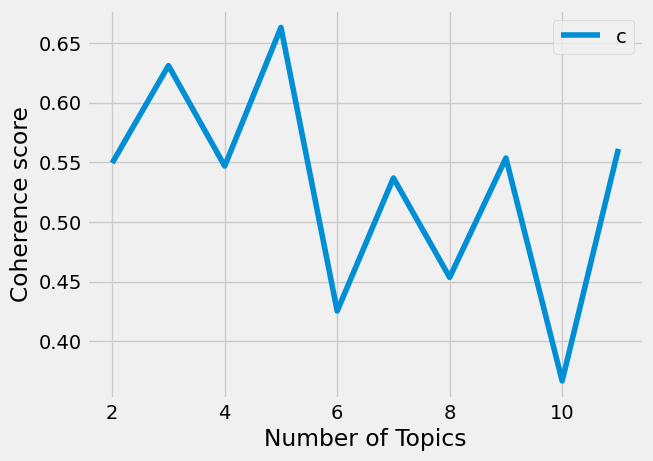

In [125]:
plot_graph(clean_text,start,stop,step)


# Model Creation

In [126]:
from gensim.models import LsiModel

def create_gensim_lsa_model(doc_clean, number_of_topics, words):
    dictionary, tfidf_matrix, tfidf_model = prepare_corpus(doc_clean)

    lsamodel = LsiModel(tfidf_matrix, num_topics=number_of_topics, id2word=dictionary)
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel


In [127]:
summary = df['summary'].dropna().tolist()

# LSA Model
number_of_topics = 7
words = 10
document_list, titles = load_data_from_dataframe(df['summary'])
clean_text=preprocess_data(document_list)
lsamodel=create_gensim_lsa_model(clean_text,number_of_topics,words)

Total Number of Documents: 387
[(0, '0.301*"eof" + 0.271*"illegal" + 0.189*"forest" + 0.180*"plantation" + 0.157*"gar" + 0.143*"plantations" + 0.107*"jaya_ptpn" + 0.107*"mill_kampar" + 0.107*"menlhk_setjen" + 0.107*"ministerial_decree"'), (1, '-0.267*"mighty_earth" + -0.264*"rapid_response" + -0.243*"ha" + -0.224*"indications" + -0.214*"deforestation" + -0.206*"concession" + -0.139*"total" + 0.132*"eof" + 0.113*"illegal" + -0.113*"sep"'), (2, '-0.393*"national_park" + -0.345*"cpo" + -0.333*"ffb" + -0.221*"contaminated" + -0.211*"tiger_corridor" + -0.211*"tesso_nilo" + -0.211*"bukit_tigapuluh" + -0.205*"bukit_betabuh" + -0.194*"alleging" + -0.186*"issued"'), (3, '0.234*"biodiversity" + 0.192*"leuser_ecosystem" + 0.182*"workers" + 0.179*"clearance" + 0.176*"allegations" + 0.163*"impact" + -0.162*"rapid_response" + -0.162*"mighty_earth" + -0.144*"indications" + 0.140*"forest"'), (4, '-0.330*"biodiversity" + -0.287*"clearance" + -0.253*"leuser_ecosystem" + -0.189*"impact" + -0.185*"forest"

In [128]:
for i, topic in lsamodel.print_topics(num_topics=7, num_words=10):
    print(f"Topic {i}: {topic}\n")

Topic 0: 0.301*"eof" + 0.271*"illegal" + 0.189*"forest" + 0.180*"plantation" + 0.157*"gar" + 0.143*"plantations" + 0.107*"jaya_ptpn" + 0.107*"mill_kampar" + 0.107*"menlhk_setjen" + 0.107*"ministerial_decree"

Topic 1: -0.267*"mighty_earth" + -0.264*"rapid_response" + -0.243*"ha" + -0.224*"indications" + -0.214*"deforestation" + -0.206*"concession" + -0.139*"total" + 0.132*"eof" + 0.113*"illegal" + -0.113*"sep"

Topic 2: -0.393*"national_park" + -0.345*"cpo" + -0.333*"ffb" + -0.221*"contaminated" + -0.211*"tiger_corridor" + -0.211*"tesso_nilo" + -0.211*"bukit_tigapuluh" + -0.205*"bukit_betabuh" + -0.194*"alleging" + -0.186*"issued"

Topic 3: 0.234*"biodiversity" + 0.192*"leuser_ecosystem" + 0.182*"workers" + 0.179*"clearance" + 0.176*"allegations" + 0.163*"impact" + -0.162*"rapid_response" + -0.162*"mighty_earth" + -0.144*"indications" + 0.140*"forest"

Topic 4: -0.330*"biodiversity" + -0.287*"clearance" + -0.253*"leuser_ecosystem" + -0.189*"impact" + -0.185*"forest" + 0.178*"linked" + 

# Coherence Score

In [129]:
dictionary, _ , _ = prepare_corpus(clean_text)

coherence_model = CoherenceModel(model=lsamodel, texts=clean_text, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model.get_coherence()
coherence_score

0.5280952600616807

# Visualizations



What is the Dominant topic and its percentage contribution in each document?

In [137]:
#Input: LSA model, corpus (in this case TFIDF matrix), text (summary column)
#Output: Dataframe consisting of every row
def format_topics_sentences(model=None, corpus=None, texts=None):
    # Collect rows in a list
    rows = []

    for i, doc in enumerate(model[corpus]):
        # Create Dict for Topic contributions, and normalize values
        total_weight = sum(abs(weight) for _, weight in doc)
        topic_dist = {
            f"Topic_{topic_id}_Perc": round((abs(weight) / total_weight) * 100, 2) # Finds and normalizes weights for each topic
            for topic_id, weight in doc
        }

        # Create Dict for Multi-Label Binary Classifcation
        topic_binary = {
            f"Topic_{topic_id}_Indicate": 0
            for topic_id, weight in doc
        }

        shared_perc = 0 # Shared contribution amongst topics given to document
        sorted_doc = sorted(topic_dist.items(), key=lambda x: abs(x[1]), reverse=True)
        dom_topic_num = 0
        dom_topic_perc = 0.0
        is_outlier = False

        # Get Dominant Topics
        itr = 0
        while (shared_perc < 50.0):
            # Get Topic Number and Topic Percentage
            topic_num, topic_perc = sorted_doc[itr]
            topic_num = int(re.search(r'\d+', topic_num).group()) # Use REGEX to grab num
            shared_perc += topic_perc
            topic_binary[f"Topic_{topic_num}_Indicate"] = 1  # Multi-Label Binary Classifcation

            # Get Prime Dominant Topic
            if itr == 0:
                dom_topic_num = topic_num
                dom_topic_perc = topic_perc
            itr += 1

            # Check if Outlier
            if (itr) > (number_of_topics/2):
                is_outlier = True

        topic_keywords = ", ".join([word for word, _ in model.show_topic(dom_topic_num)])

        # Create Row for Document
        row = {
            'Dominant_Topic': int(dom_topic_num),
            'Perc_Contribution': dom_topic_perc,
            'Topic_Keywords': topic_keywords,
            'Text': texts[i],
            'Is_Outlier': is_outlier,
            'Dom_Topics_Num': itr
        }
        row.update(topic_dist) # Add individual topic contributions
        row.update(topic_binary) # Add Multi-Label Binary Classifcation for topics
        rows.append(row)

    # Create DataFrame
    sent_topics_df = pd.DataFrame(rows)
    return sent_topics_df

In [142]:
_ , tfidf_matrix , _ = prepare_corpus(clean_text)


# Format
dominant_topic_df = format_topics_sentences(model=lsamodel, corpus=tfidf_matrix, texts=document_list).reset_index()


In [147]:
dominant_topic_df[dominant_topic_df['Dominant_Topic'] == 3]

,index,Dominant_Topic,Perc_Contribution,Topic_Keywords,Text,Is_Outlier,Dom_Topics_Num,Topic_0_Perc,Topic_1_Perc,Topic_2_Perc,...,Topic_4_Perc,Topic_5_Perc,Topic_6_Perc,Topic_0_Indicate,Topic_1_Indicate,Topic_2_Indicate,Topic_3_Indicate,Topic_4_Indicate,Topic_5_Indicate,Topic_6_Indicate
0,0,3,26.24,"biodiversity, leuser_ecosystem, workers, clear...",That the Respondent allegedly transferred the ...,False,2,3.24,6.03,8.61,...,9.50,25.02,21.36,0,0,0,1,0,1,0
1,1,3,26.89,"biodiversity, leuser_ecosystem, workers, clear...",The Complainant alleges that the Respondent ha...,False,3,4.11,7.19,7.94,...,13.18,20.11,20.58,0,0,0,1,0,1,1
2,2,3,29.86,"biodiversity, leuser_ecosystem, workers, clear...",1.The Complainant alleges that the Respondent ...,False,3,10.50,12.02,8.96,...,14.55,18.93,5.16,0,0,0,1,1,1,0
3,3,3,28.10,"biodiversity, leuser_ecosystem, workers, clear...",The Respondent's Corporate Social Responsibili...,False,2,22.39,5.25,6.10,...,17.06,17.40,3.69,1,0,0,1,0,0,0
4,4,3,39.09,"biodiversity, leuser_ecosystem, workers, clear...",The Complainant alleges that the Respondent br...,False,2,13.53,23.37,5.15,...,11.07,2.78,4.99,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
367,367,3,33.19,"biodiversity, leuser_ecosystem, workers, clear...",Alleged involvement in labour right issues by ...,False,2,6.52,15.59,10.06,...,20.88,3.71,10.05,0,0,0,1,1,0,0
369,369,3,31.56,"biodiversity, leuser_ecosystem, workers, clear...",Alleged human rights violation by Dinant,False,2,5.27,7.93,10.22,...,17.89,23.63,3.50,0,0,0,1,0,1,0
376,376,3,29.66,"biodiversity, leuser_ecosystem, workers, clear...",Alleged labour rights violation in Malaysian g...,False,3,11.80,7.74,7.62,...,18.53,16.35,8.29,0,0,0,1,1,1,0
378,378,3,29.19,"biodiversity, leuser_ecosystem, workers, clear...",Alleged forest clearance and involvement in la...,False,2,12.89,15.63,0.99,...,14.80,25.62,0.88,0,0,0,1,0,1,0


## Topic Frequency

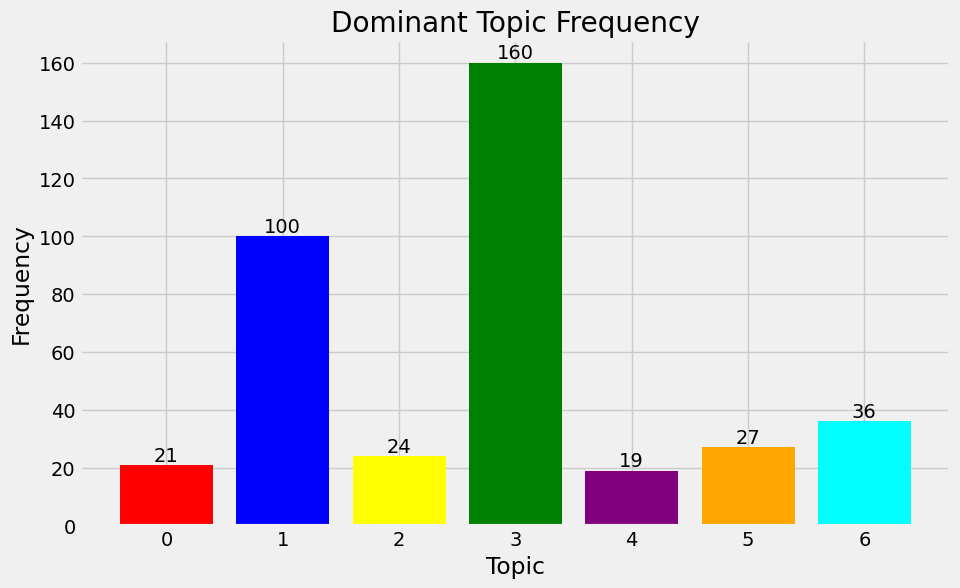

In [144]:
# Prepare data
topics_df = dominant_topic_df.groupby(['Dominant_Topic'])['index'].count().reset_index()
indexes = topics_df['Dominant_Topic']
values = topics_df['index']
colors_7 = ['red', 'blue', 'yellow', 'green', 'purple', 'orange', 'cyan']

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(indexes, values, color=colors_7[:len(indexes)])
ax.bar_label(bars)

# Labels and title
ax.set_title('Dominant Topic Frequency')
ax.set_xlabel('Topic')
ax.set_ylabel('Frequency')
plt.show()

## Wordclouds

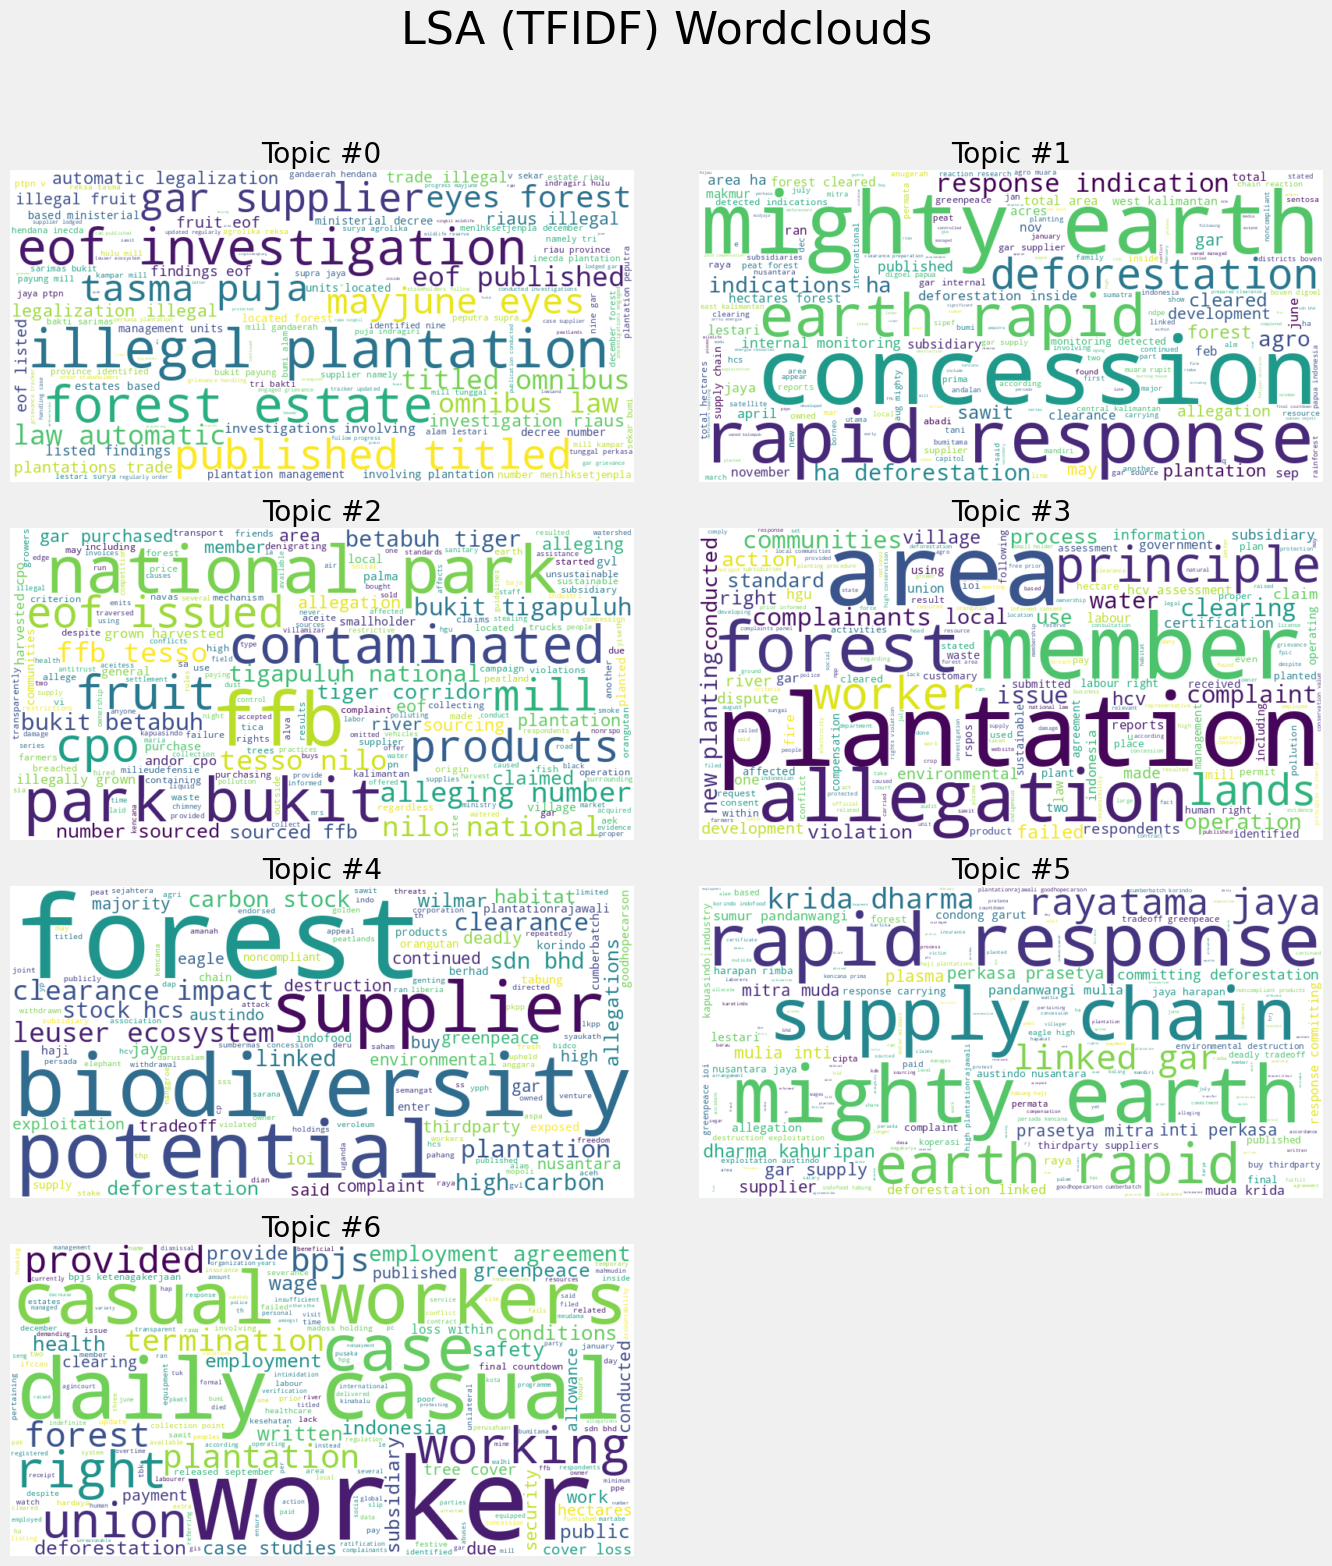

In [146]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import re

# Input: Receives dataframe containing all rows with classification, table title, and number of topics
# Output: Displays n word clouds
def display_wordcloud(df, title, n_topics):

  n_cols = 2
  n_rows = int(np.ceil(n_topics / n_cols))
  fig = plt.figure(figsize=(14, 4 * n_rows))

  for topic in range(n_topics):
    topic_df = dominant_topic_df[dominant_topic_df['Dominant_Topic'] == topic]
    text = ' '.join(topic_df['Text'].astype(str).tolist()) # Joining the words of each text of each row into a list separated by ' '
    text = re.sub(r'[^A-Za-z\s]', '', text) # Substituting/deleting anything that IS NOT a letter Aa-Zz with ''
    text = text.lower()
    en_stop = set(stopwords.words('english') + stopwords_extra)
    text = ' '.join(word for word in text.split() if word not in en_stop)

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    ax = fig.add_subplot(n_rows, n_cols, topic + 1)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(f"Topic #{topic}")
    ax.axis("off")

  fig.suptitle(title, fontsize=32)
  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()


display_wordcloud(df=dominant_topic_df, title='LSA (TFIDF) Wordclouds', n_topics=number_of_topics)